In [33]:
from numpy import genfromtxt
import numpy as np
import math
from pylab import *
import urllib
import os
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.metrics import mean_squared_error
from __future__ import division
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lmfit import Model
pl.style.use('seaborn-dark-palette')
pl.rc('font',family='Arial')

### constants

In [7]:
temp = 300.
Ms = 420000.
kb = 1.381e-23 
tau0 = 1e-10
mu0 = 4*np.pi*1e-7

In [8]:
def visc_calc(T, mass_fraction):
    glycerolDen = (1273.3-0.6121*T)/1000 			#Density of Glycerol (g/cm3)
    waterDen = (1-math.pow(((abs(T-4))/622),1.7)) 	#Density of water (g/cm3)
    
    ##Andreas Volk polynomial method
    contraction_av = 1-math.pow(3.520E-8*((mass_fraction*100)),3)+math.pow(1.027E-6*((mass_fraction*100)),2)+2.5E-4*(mass_fraction*100)-1.691E-4
    contraction = 1+contraction_av/100
    
    glycerolVisc=0.001*12100*np.exp((-1233+T)*T/(9900+70*T))
    waterVisc=0.001*1.790*np.exp((-1230-T)*T/(36100+360*T))
    
    a=0.705-0.0017*T
    b=(4.9+0.036*T)*np.power(a,2.5)
    alpha=1-mass_fraction+(a*b*mass_fraction*(1-mass_fraction))/(a*mass_fraction+b*(1-mass_fraction))
    A=np.log(waterVisc/glycerolVisc)
    
    viscosity_mix=glycerolVisc*np.exp(A*alpha)
    
    return viscosity_mix

def power(my_list, p):
    return [ x**p for x in my_list ]

def calc_neel(size, k):
    neel = []
    for x in range(len(size)):
        neel.append(tau0*np.exp(k[x]*4*np.pi*(1e-9*float(size[x]))**3*(24*kb*temp)**(-1)))
    return neel

def calc_brown(eta, hsize):
    brown = []
    for x in range(len(eta)):
        brown.append(eta[x]*np.pi*(hsize[x]*1e-9)**3*(2*kb*temp)**(-1))
    return brown

def vol(my_list):
    return[ np.pi*(1e-9*x)**3/6. for x in my_list ]


### import simulation data to data frame

In [9]:
freqs = []
fields = []
size = []
third = []
fifth = []
hsize = []
sigma = []
eta = []
b = []
K = []
phase1 = []
phase3 = []
gyro = []

for f in os.listdir('fits'):
    if f[-1] == 'v':
        filename = 'fits/' + f
        filedata = np.genfromtxt(filename, delimiter=',')
        f = f[:-4]
        s = str.split(f,"_")
        size.append(float(s[0][:-2]))
        fields.append(float(s[1][:-2]))
        freqs.append(int(s[2][:-3])*1000)
        sigma.append(0.1)
        eta.append(8.9e-4)
        moment = filedata[:,1]
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        phase1.append(np.angle(np.fft.fft(moment)[1]))
        phase3.append(np.angle(np.fft.fft(moment)[3]))
        if s[-1] == "frozen":
            b.append("off")
        else:
            b.append("on")     
        g = 1.
        h = 50.
        k = 5000.
        for ss in range(2,len(s)):
            if s[ss][0] == "g":
                g = float(s[ss][1:])
            if s[ss][0] == "K":
                k = 1000*float(s[ss][1:])
                if k > 25000:
                    k /= 1000.
            if s[ss][0] == "H":
                h = float(s[ss][1:])
        K.append(k)
        hsize.append(h)
        gyro.append(g)
            
sdata = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'sigma': sigma, \
                     'third': third, 'fifth': fifth, 'hsize': hsize, 'eta': eta, 'b': b, \
                     'K': K, 'phase1': phase1, 'phase3': phase3, 'gyro': gyro})

sdata['5:3'] = sdata['fifth']/sdata['third']
sdata['angF'] = 2*np.pi*sdata['frequency']
sdata['Vc'] = vol(sdata['size'])
sdata['Ms'] = 393023 * (1 - np.exp(-2.78258e8 * sdata['size']*1e-9))**57.87571 
sdata['tauB'] = calc_brown(sdata['eta'],sdata['hsize'])
sdata['tauN'] = calc_neel(sdata['size'], sdata['K'])
sdata['tan1'] = abs(np.tan(sdata['phase1']))
sdata['tan3'] = abs(np.tan(sdata['phase3']))
sdata['tau'] = sdata['tan1']/sdata['angF']

for index, row in sdata.iterrows():
    T = row['frequency']**(-1)
    t = np.arange(0,T,T/1000.)
    H = 0.001*row['field']*np.cos(row['angF']*t)
    V = (4/3)*np.pi*(row['size']*1e-9/2)**3
    xi = row['Ms']*V*H/(kb*temp)
    L = np.cosh(xi)/np.sinh(xi) - 1/xi
    sdata.loc[index,'L5:3'] = abs(np.fft.fft(L)[5])/abs(np.fft.fft(L)[3])

### train model

In [14]:
mldata = sdata[(sdata['b'] == 'off') & (sdata['field'] > 2) & (sdata['size'] > 12)& (sdata['K'] == 5000)& (sdata['gyro'] == 1)& (sdata['hsize'] == 50)]
X = mldata[['field','frequency','size']]
Y = mldata[['tan1']]
X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.15,random_state=26)
model = RandomForestRegressor(n_estimators=100, max_features=3)
model.fit(X_train, Y_train.values.ravel())
print(model.score(X_train,Y_train))

0.999793686945


### predict: field, frequency, size

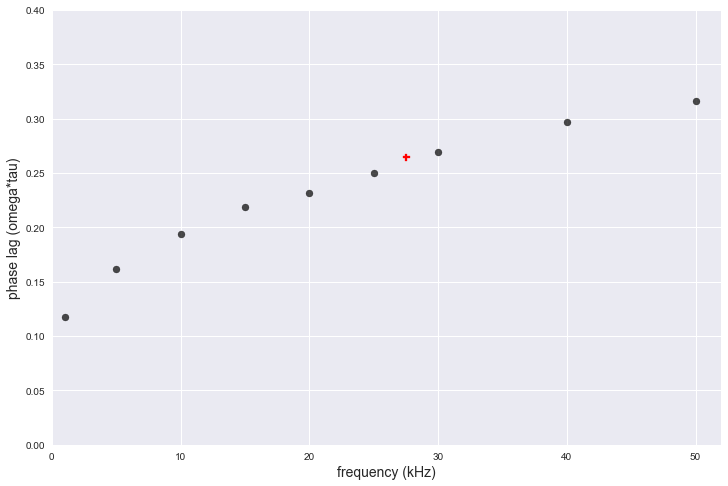

In [55]:
field = 32.5
frequency = 27532
size = 28

field_sub = 32
size_sub = 28

p = model.predict([[field,frequency,size]])
sub = mldata[(mldata['field'] == field_sub) & (mldata['size'] == size_sub)]
sub = sub.sort_values(by=['frequency'])

fig, ax = pl.subplots(figsize=(12,8))
pl.scatter(sub['frequency']/1000., sub['tan1'],c="black",alpha=0.7)
pl.scatter(frequency/1000., p, marker='P',c="red")
pl.ylabel('phase lag (omega*tau)',fontsize=14)
pl.xlabel('frequency (kHz)',fontsize=14)

pl.xlim(0,52)
pl.ylim(0,0.4)
pl.show()